In [1]:
import scanpy
import numpy as np
import pandas as pd
from sklearn import decomposition
import phate
import matplotlib.pyplot as plt
import scprep
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import ranksums, pearsonr

In [12]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')

In [3]:
adata_ref = scanpy.read_h5ad('data/mouse_atlas_with_embryonic.h5ad')

In [4]:
intersection_genes = np.array(list(set(adata_beta.var_names).intersection(adata_ref.var_names)))
print('Number of intersection genes', len(intersection_genes))

Number of intersection genes 16325


In [13]:
dataset_cmap = sns.color_palette('Accent', n_colors=8) + sns.color_palette('Dark2', n_colors=1)
dataset_cmap = dict(zip(adata_ref.obs['dataset'].unique(), dataset_cmap))

In [10]:
def darken_color(color, amount=2):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [13]:
colors = list(sns.color_palette('Set1', n_colors=4)) + \
list(sns.color_palette('Paired', n_colors=3)) + ['lightgray'] + \
list(sns.color_palette('Set2', n_colors=7).as_hex())

at_cmap = dict(zip(adata_beta.obs['AT_committment'].cat.categories, colors))
at_order = ['WT AT 1', 'WT AT 2', 'WT AT 3', 'WT AT 4', 'WT AT 5', 'WT AT 6', 'WT AT 7',
            'HFD AT 1', 'HFD AT 2', 'HFD AT 3', 'HFD AT 4', 'OB/OB AT 1', 'OB/OB AT 2', 'OB/OB AT 3', 'Uncommitted']
at_cmap = dict(zip(at_order, [at_cmap[key] for key in at_order]))

In [12]:
# convert Theiler stage to just embryonic
convert = {'Theiler stage 20': 'embryonic', 'Theiler stage 22': 'embryonic', 'Theiler stage 23': 'embryonic',
          '2 weeks':'2 weeks', '2 month-old stage':'2 month-old stage', '4 month-old stage':'4 month-old stage',
           '6 month-old stage':'6 month-old stage', '20 month-old stage and over':'20 month-old stage and over'}

## scMMGAN

In [ ]:
out = np.load(f'results/output_mouse_normal_to_all_cycle_1_correspondence_15_corr_correspondence_all_training_counter_normal_t2d.npz')
ctrl_magan = pd.DataFrame(out['sample_to_all'], index=adata_ref.obs_names, columns=adata_beta.var_names)
ctrl_int = ctrl_magan[intersection_genes]
adata_beta_mean = adata_beta.to_df()[intersection_genes].mean(axis=0)
ctrl_int = ctrl_int - ctrl_int.mean(axis=0) + adata_beta_mean
mask_not_in_intersection = [x not in intersection_genes for x in ctrl_magan.columns]
ctrl_magan = pd.concat((ctrl_magan.iloc[:, mask_not_in_intersection], ctrl_int), axis=1)
ctrl_magan = ctrl_magan[adata_beta.var_names]

In [10]:
adata_ref = adata_ref[adata_ref.obs['dataset__design__sample'] != 'embryonic__E13.5__E13_5'] # 1 beta cell from this dataset

In [11]:
adata_ref = adata_ref[adata_ref.obs['diabetes_model'] != 'T1D_NOD_prediabetic'] ## some mapped were "normal" disease but NOD mice

In [12]:
ctrl_magan = ctrl_magan.loc[adata_ref.obs_names]

## PHATE mapping

In [13]:
pc_op = decomposition.PCA(n_components=100, random_state=42)
data_pc= pc_op.fit_transform(adata_beta.to_df())
ref_data_pc = pc_op.transform(ctrl_magan)

In [14]:
phate_op = phate.PHATE(random_state=42, n_components=3, verbose=False)
data_phate = phate_op.fit_transform(data_pc)
ref_data_phate = phate_op.transform(ref_data_pc)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [15]:
adata_ref.obsm['X_scmmgan_pc'] = ref_data_pc
adata_ref.obsm['X_scmmgan_phate'] = ref_data_phate

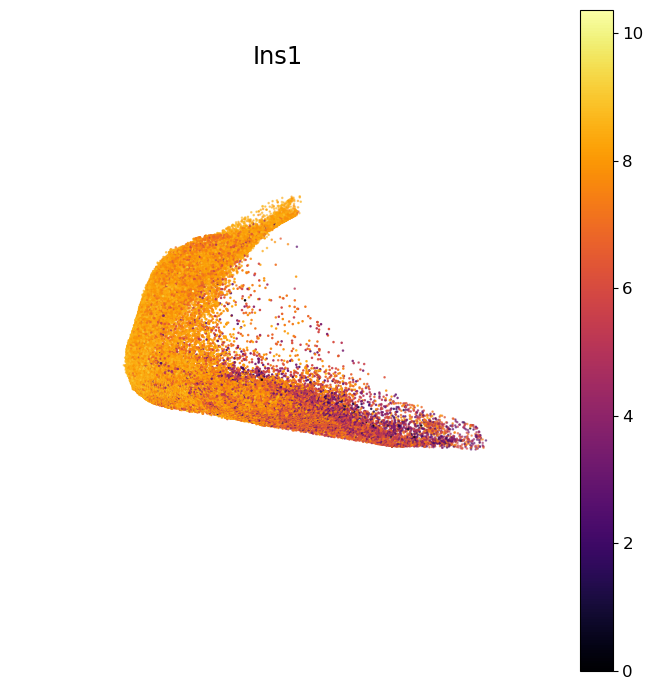

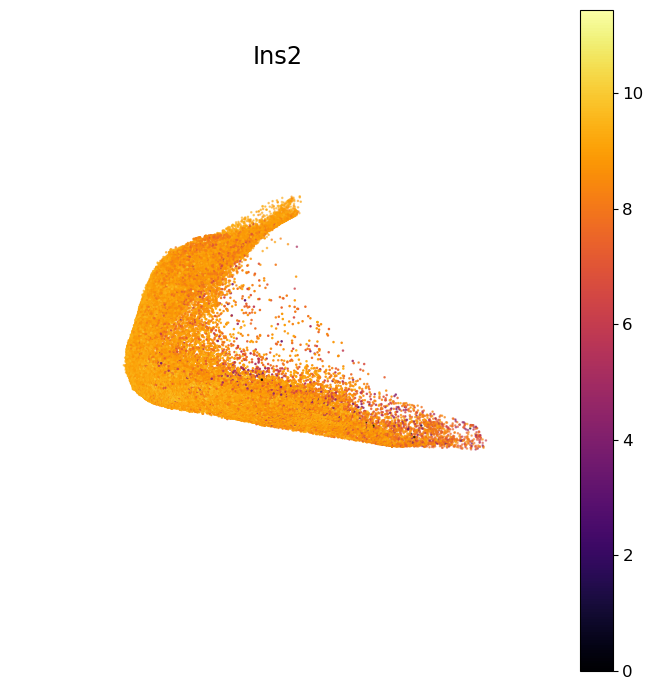

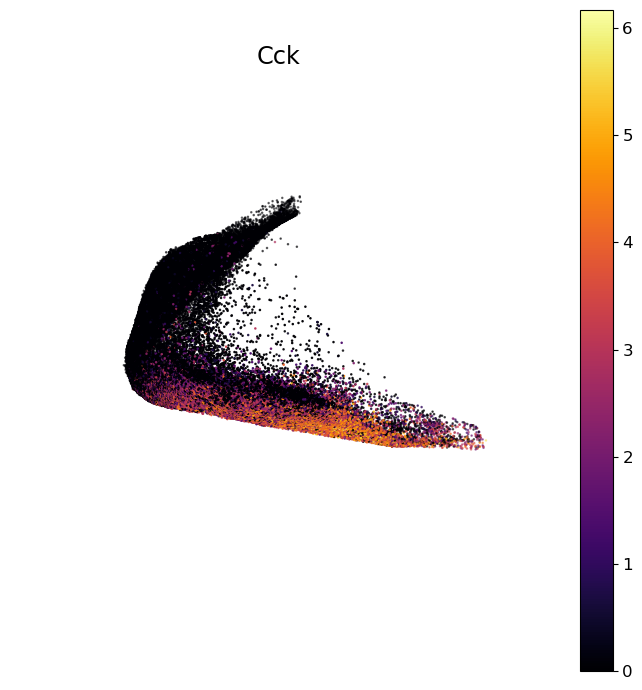

In [45]:
for gene in ['Ins1', 'Ins2', 'Cck']:
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=adata_ref[:,adata_ref.var['feature_name'].isin([gene])].to_df(),
                          azim=-30, elev=50, ticks=None, legend_loc=(1.02, 0), ax=ax, title=gene)
    plt.tight_layout()
    ax.axis('off')
    fig.savefig(f'figures/mapped_{gene}.png', dpi=300)

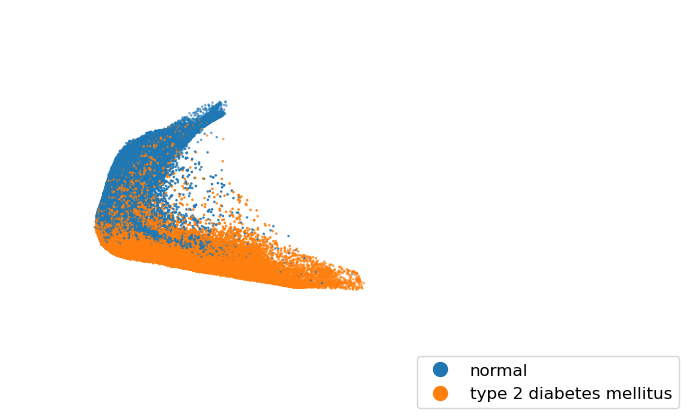

In [46]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=adata_ref.obs['disease'], azim=-30, elev=50, ticks=None, legend_loc=(1.02, 0), ax=ax)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/mapped_disease.png', dpi=300)

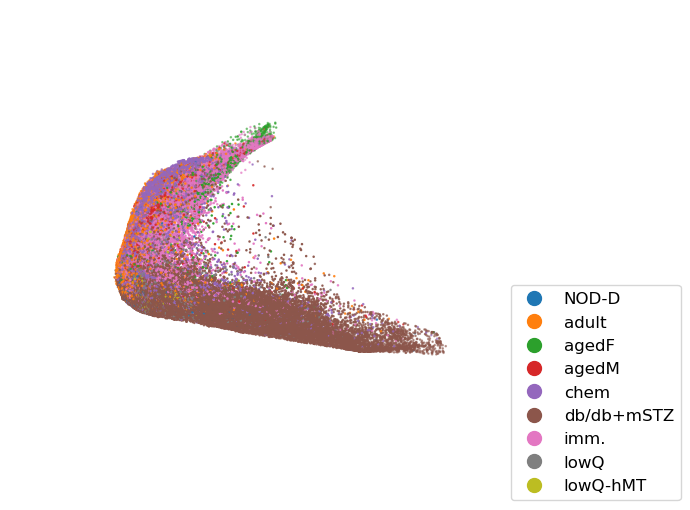

In [47]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=adata_ref.obs['cell_subtype_beta_coarse_reannotatedIntegrated'], azim=-30, elev=50, ticks=None, legend_loc=(1.02, 0), ax=ax)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/mapped_coarse.png', dpi=300)

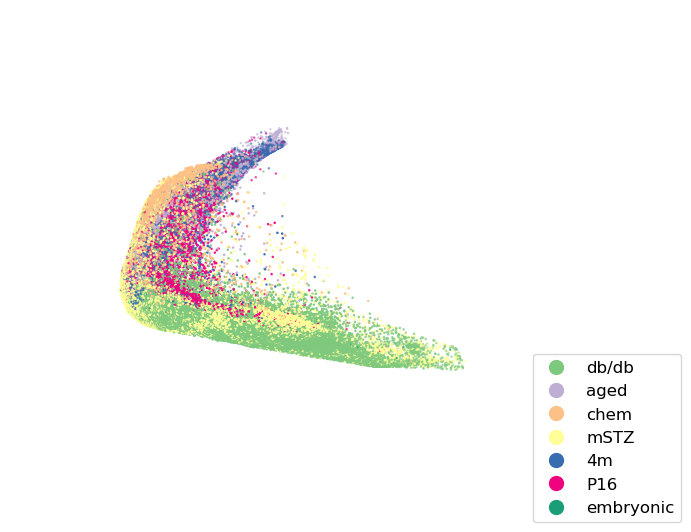

In [48]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=adata_ref.obs['dataset'], azim=-30, elev=50,
                      ticks=None, legend_loc=(1.02, 0), ax=ax, cmap=dataset_cmap)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/mapped_dataset.png', dpi=300)

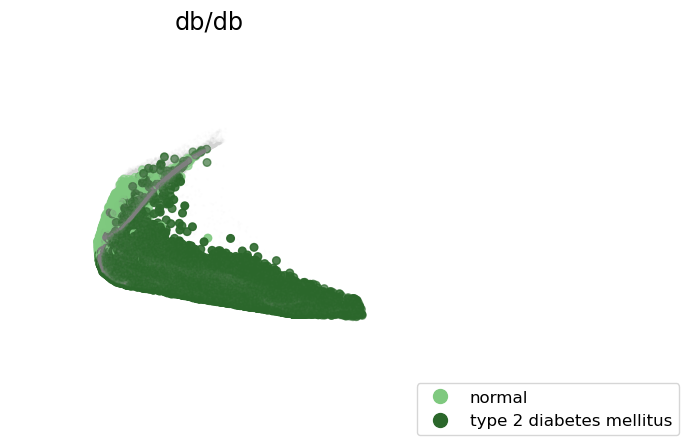

<Figure size 640x480 with 0 Axes>

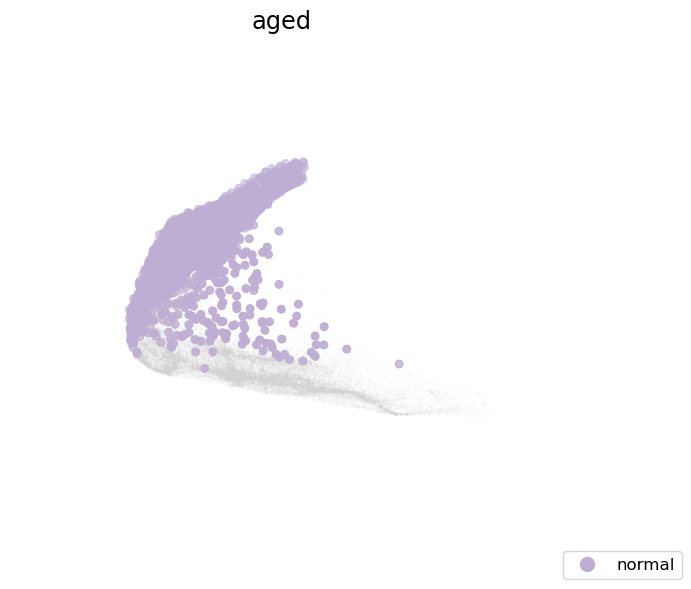

<Figure size 640x480 with 0 Axes>

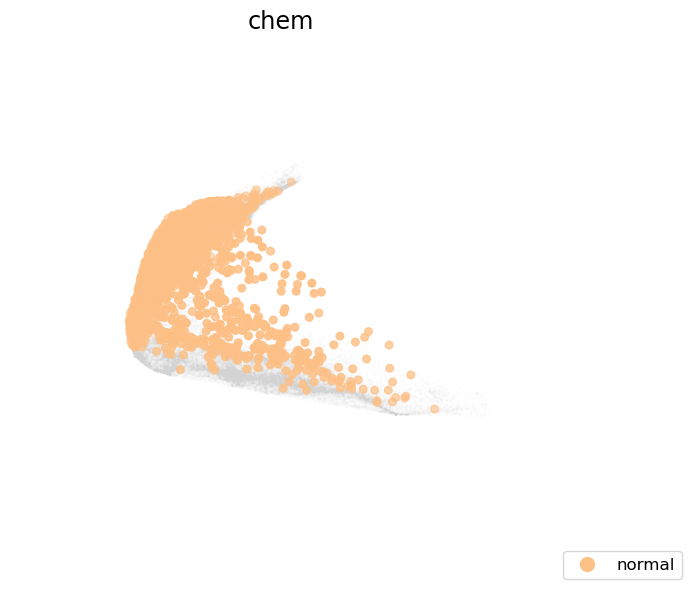

<Figure size 640x480 with 0 Axes>

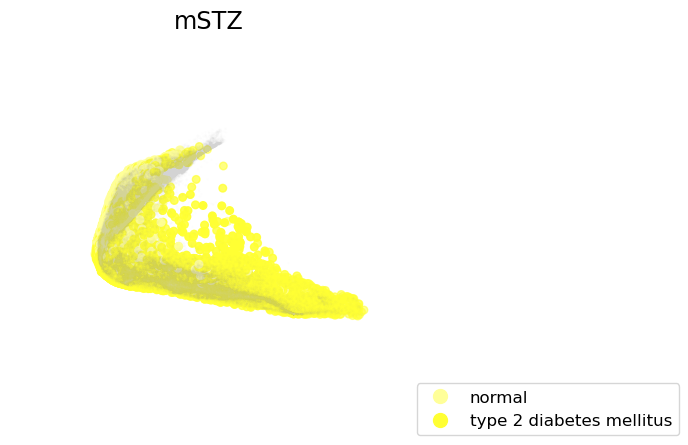

<Figure size 640x480 with 0 Axes>

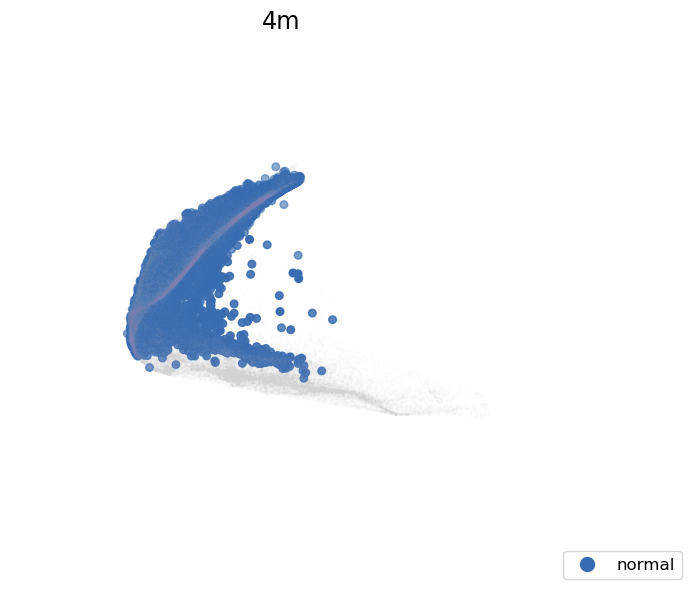

<Figure size 640x480 with 0 Axes>

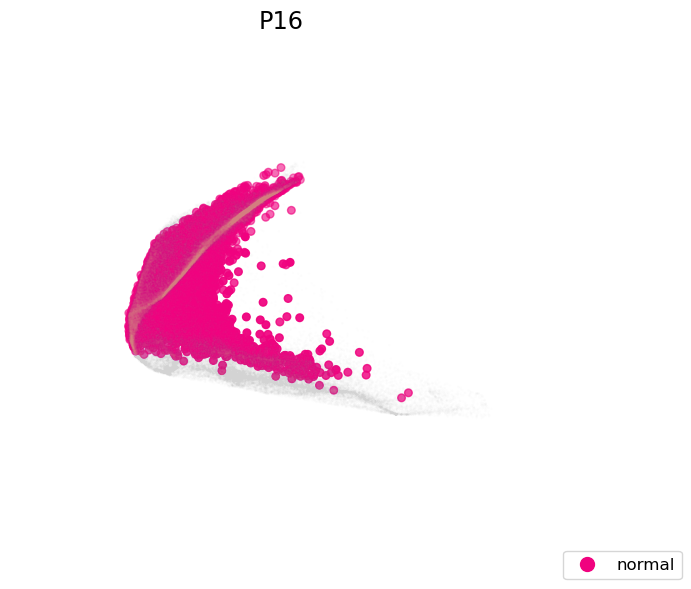

<Figure size 640x480 with 0 Axes>

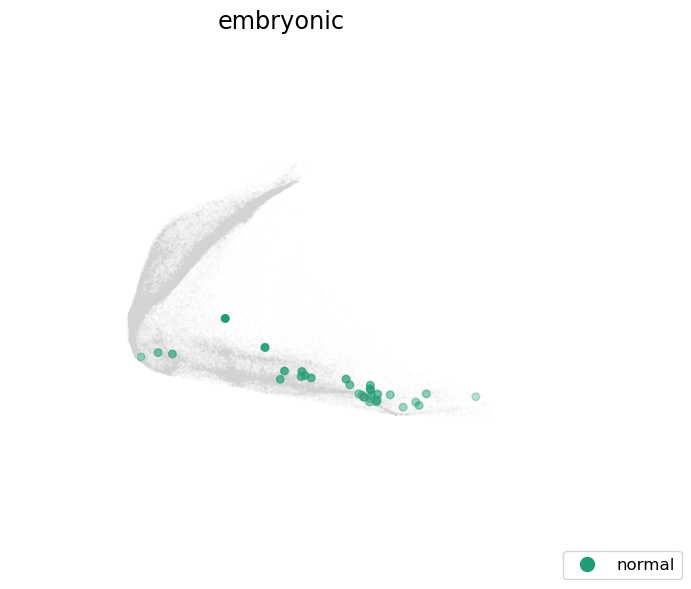

<Figure size 640x480 with 0 Axes>

In [89]:
for dataset in adata_ref.obs['dataset'].unique():
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c='lightgray', azim=-30, elev=50,
                          ticks=None, legend_loc=(1.02, 0), ax=ax, alpha=0.01,
                          mask=adata_ref.obs['dataset'] != dataset)
    scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=adata_ref.obs['disease'], azim=-30, elev=50, s=30,
                          ticks=None, legend_loc=(1.02, 0), ax=ax,
                          cmap = {'normal': dataset_cmap[dataset], 'type 2 diabetes mellitus': darken_color(dataset_cmap[dataset])},
                          mask=adata_ref.obs['dataset'] == dataset, title=dataset)
    plt.tight_layout()
    ax.axis('off')
    if '/' in dataset:
        dataset = dataset.replace('/', '_')
    fig.savefig(f'figures/mapped_dataset_{dataset}.png', dpi=300)
    plt.show(); plt.clf()

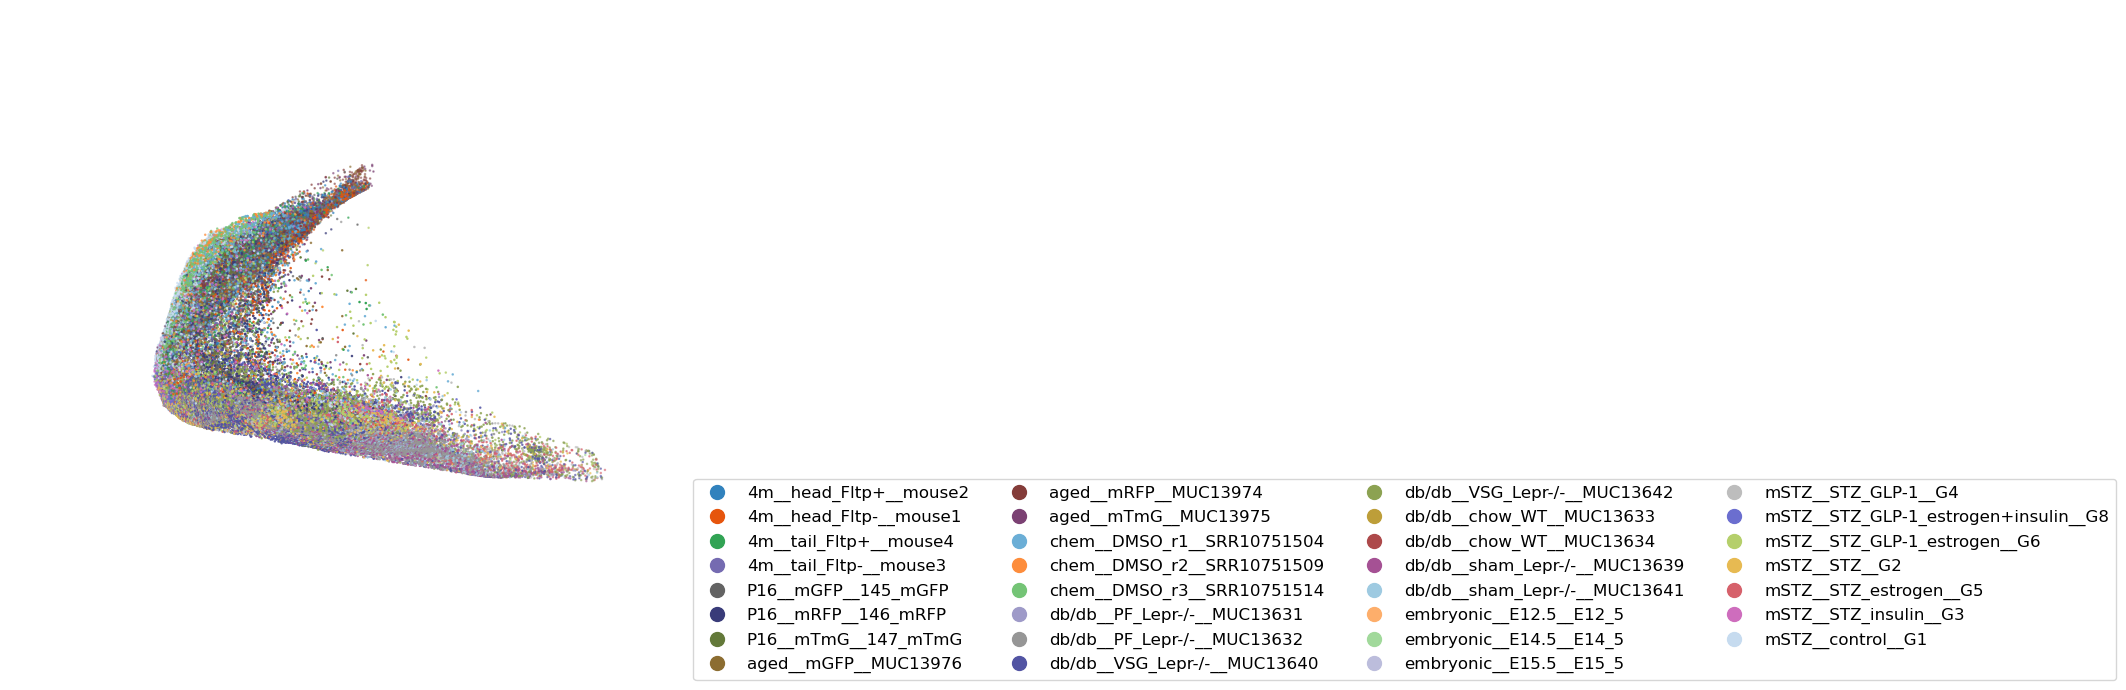

In [50]:
fig = plt.figure(figsize=(30,7))
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=adata_ref.obs['dataset__design__sample'], azim=-30, elev=50, ticks=None, 
                      legend_loc=(1.02, 0), ax=ax)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/mapped_dataset__design__sample.png', dpi=300)

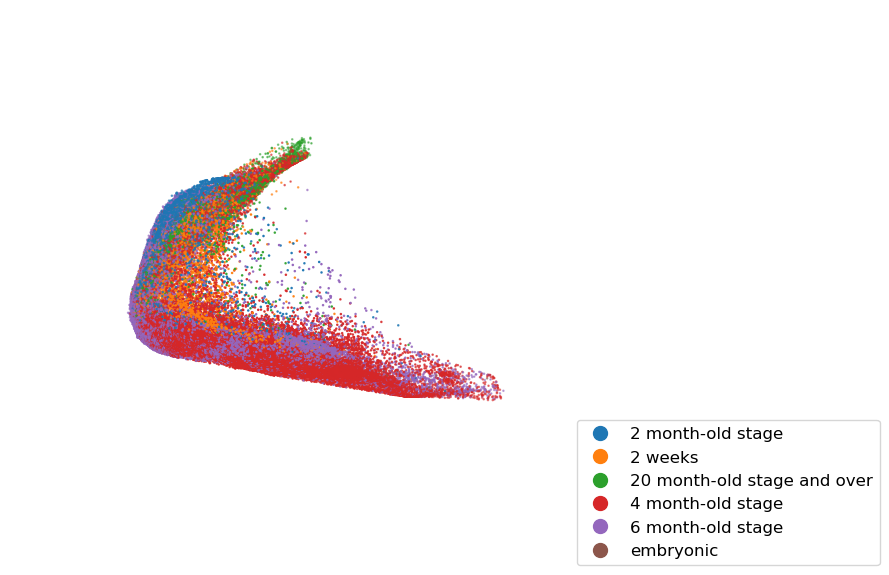

In [66]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=adata_ref.obs['development_stage'].map(convert),
                      azim=-30, elev=50, ticks=None, legend_loc=(1.02, 0), ax=ax)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/mapped_development_stage.png', dpi=300)

## Map archetypes

In [17]:
dist = cdist(ref_data_pc, data_pc)
nearest_cells = adata_beta.obs_names[np.argsort(dist, axis=1)[:, 0]]

In [18]:
mouse_atlas_at_comms = adata_beta.obs['AT_committment'].loc[nearest_cells]
mouse_atlas_at_comms.index = adata_ref.obs_names

In [19]:
adata_ref.obs['AT_committment'] = mouse_atlas_at_comms
adata_ref.obs['AT_committment'] = adata_ref.obs['AT_committment'].astype('category')

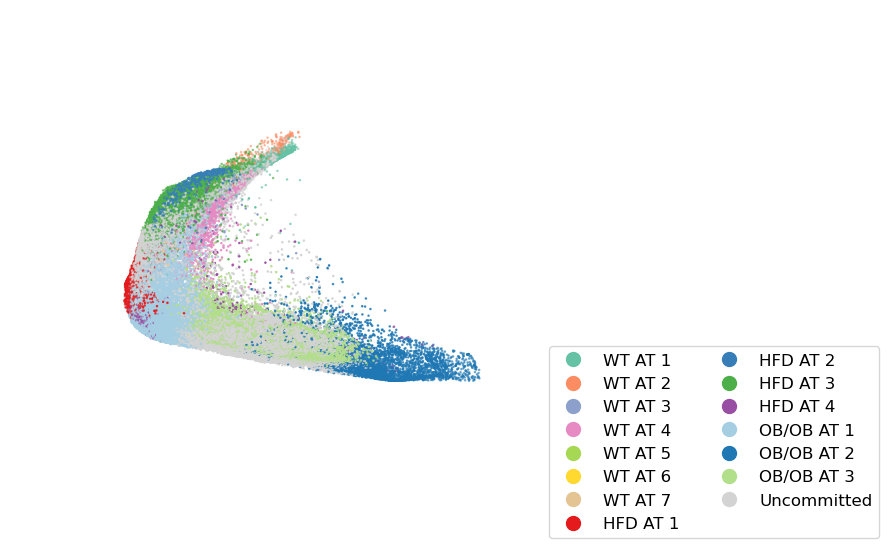

In [20]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(adata_ref.obsm['X_scmmgan_phate'], c=mouse_atlas_at_comms, azim=-30, elev=50, ticks=None, legend_loc=(1.02, 0), ax=ax, cmap=at_cmap)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/mapped_at_committment.png', dpi=300)

In [ ]:
adata_ref.write('data/mouse_atlas_with_embryonic.h5ad', compression='gzip')
np.savez_compressed('results/output_mouse_normal_to_all_cycle_1_correspondence_15_corr_correspondence_all_training_counter_normal_t2d_filtered.npz',
                    ctrl_magan.values)

# Archetypal proportion per sample, developmental stage

In [2]:
adata_ref = scanpy.read_h5ad('data/mouse_atlas_with_embryonic.h5ad')

In [3]:
sns.set_style('white')

In [4]:
normal_adata_ref = adata_ref[adata_ref.obs['disease'] == 'normal'].obs.sort_values(by='AT_committment')
t2d_adata_ref = adata_ref[adata_ref.obs['disease'] == 'type 2 diabetes mellitus'].obs.sort_values(by='AT_committment')

In [5]:
normal_adata_ref['dataset__design__sample'].value_counts().shape

(19,)

In [6]:
t2d_adata_ref['dataset__design__sample'].value_counts().shape

(12,)

/tmp/ipykernel_271739/3424979183.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


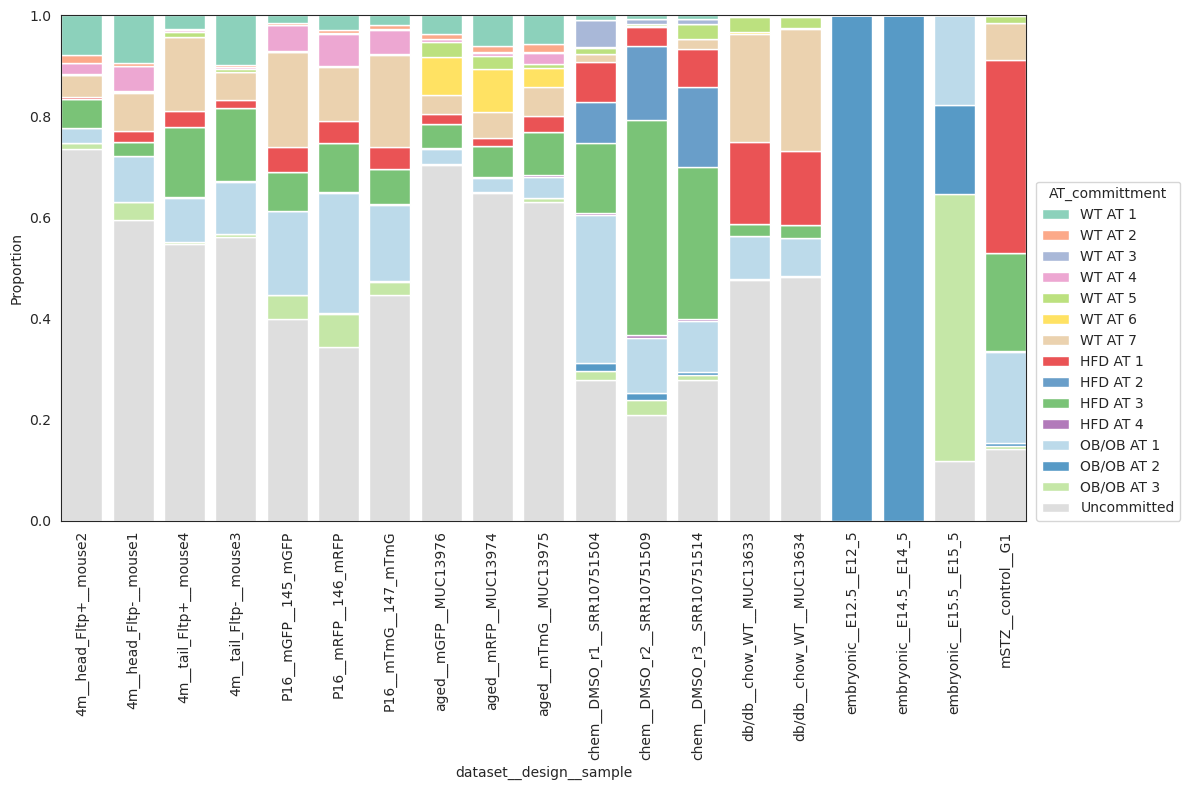

In [14]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(
    data=normal_adata_ref,
    x="dataset__design__sample", hue="AT_committment",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8, palette=at_cmap, hue_order=at_order,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.move_legend(ax, (1.01, 0))
plt.tight_layout()
fig.savefig('figures/normal_archetypal_proportions.png', dpi=300)

/tmp/ipykernel_271739/3331376540.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


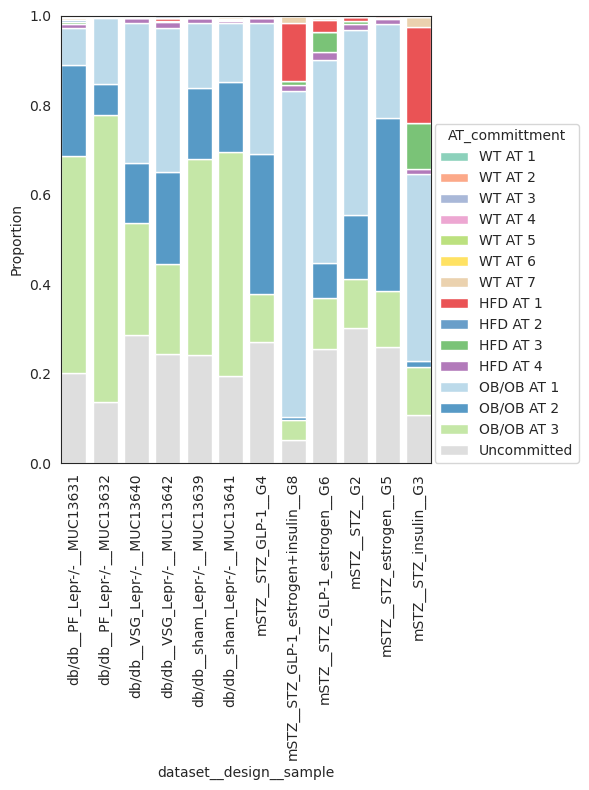

In [15]:
fig = plt.figure(figsize=(6,8))
ax = sns.histplot(
    data=t2d_adata_ref,
    x="dataset__design__sample", hue="AT_committment",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8, palette=at_cmap, hue_order=at_order,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.move_legend(ax, (1.01, 0))
plt.tight_layout()
fig.savefig('figures/t2d_archetypal_proportions.png', dpi=300)

### Are WT4, OBOB2/3 associated with age in non-diabetic mice? 

In [7]:
adata_ref = adata_ref[adata_ref.obs['disease'] == 'normal'] # only non-diabetic mice for this comparison

In [8]:
datasets = adata_ref.obs['dataset'].unique()

In [9]:
dataset_adata_refs = {}
for dataset in datasets:
    dataset_adata_refs[dataset] = adata_ref[adata_ref.obs['dataset'] == dataset].obs.sort_values(by='AT_committment')

In [14]:
dataset_proportions = {}
for dataset in datasets:
    all_proportions = pd.DataFrame(index=at_order)
    for id in dataset_adata_refs[dataset]['dataset__design__sample'].unique():
        df = pd.DataFrame(index=at_order).join(other=dataset_adata_refs[dataset][dataset_adata_refs[dataset]['dataset__design__sample'] == id]['AT_committment'].value_counts())
        df.columns = [id]
        all_proportions = pd.concat((all_proportions, df),axis=1 )
    dataset_all_proportions = all_proportions.fillna(0)
    dataset_all_proportions = (dataset_all_proportions/dataset_all_proportions.sum(axis=0))
    dataset_proportions[dataset] = dataset_all_proportions

In [15]:
dataset_proportions = np.array(list(dataset_proportions.items()))

/tmp/ipykernel_3197739/2498482807.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset_proportions = np.array(list(dataset_proportions.items()))


P16 WT AT 4 0.007290358091535638


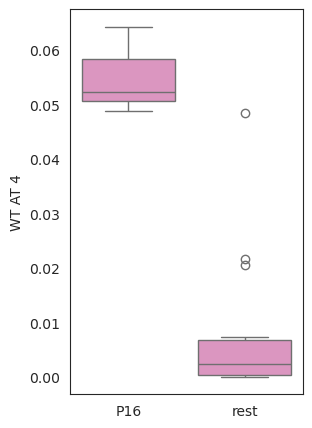

In [16]:
i = np.where(datasets == 'P16')[0][0]
at = 'WT AT 4'
name = dataset_proportions[i][0]
pval = ranksums(dataset_proportions[i][1].loc[at], 
                pd.concat([x[1] for x in dataset_proportions[np.arange(0,7)!= i]], axis=1).loc[at]).pvalue

print (name, at, pval)
fig = plt.figure(figsize=(3,5))
props = pd.concat([dataset_proportions[i][1].loc[at], pd.concat([x[1] for x in dataset_proportions[np.arange(0,7)!= i]], axis=1).loc[at]])
ax = sns.boxplot(x=[name]*dataset_proportions[i][1].shape[1] + ['rest']*pd.concat([x[1] for x in dataset_proportions[np.arange(0,7)!= i]], axis=1).shape[1], y=props, color=at_cmap[at])
if '/' in at:
    at = at.replace('/', '_')
if '/' in name:
    name = name.replace('/', '_')
fig.savefig(f'figures/{name}_{at}_proportions_boxplot.png', dpi=300)

embryonic OB/OB AT 2 0.007290358091535638


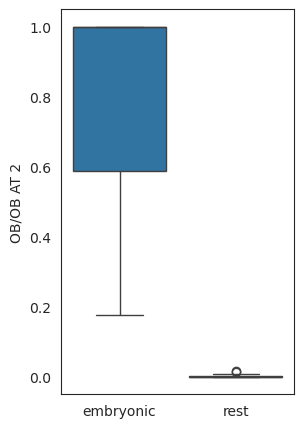

In [22]:
i = np.where(datasets == 'embryonic')[0][0]
at = 'OB/OB AT 2'
name = dataset_proportions[i][0]
pval = ranksums(dataset_proportions[i][1].loc[at], 
                pd.concat([x[1] for x in dataset_proportions[np.arange(0,7)!= i]], axis=1).loc[at]).pvalue

print (name, at, pval)
fig = plt.figure(figsize=(3,5))
props = pd.concat([dataset_proportions[i][1].loc[at], pd.concat([x[1] for x in dataset_proportions[np.arange(0,7)!= i]], axis=1).loc[at]])
ax = sns.boxplot(x=[name]*dataset_proportions[i][1].shape[1] + ['rest']*pd.concat([x[1] for x in dataset_proportions[np.arange(0,7)!= i]], axis=1).shape[1], y=props, color=at_cmap[at])
if '/' in at:
    at = at.replace('/', '_')
if '/' in name:
    name = name.replace('/', '_')
fig.savefig(f'figures/{name}_{at}_proportions_boxplot.png', dpi=300)

In [21]:
all_proportions = pd.concat([x[1] for x in dataset_proportions], axis=1).T
dev_stage = adata_ref.obs[['dataset__design__sample', 'development_stage']].drop_duplicates().set_index('dataset__design__sample').loc[all_proportions.index]
age = adata_ref.obs[['dataset__design__sample', 'age']].drop_duplicates().set_index('dataset__design__sample').loc[all_proportions.index]
all_proportions = pd.concat((all_proportions, dev_stage, age), axis=1)

In [22]:
all_proportions['development_stage'] = all_proportions['development_stage'].map(convert)

In [25]:
all_proportions['development_stage'] = pd.Categorical(all_proportions['development_stage'], 
               categories = ['embryonic', '2 weeks', '2 month-old stage', '4 month-old stage',
                             '6 month-old stage', '20 month-old stage and over'],
               ordered=True)

/tmp/ipykernel_271739/2273583555.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


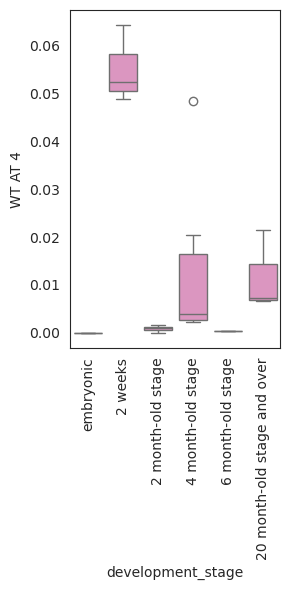

In [26]:
fig = plt.figure(figsize=(3,6))
ax = sns.boxplot(x=all_proportions['development_stage'],
                 y=all_proportions['WT AT 4'], color=at_cmap['WT AT 4'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
fig.savefig('figures/WT_AT_4_development_stage_boxplot.png', dpi=300)

In [ ]:
p16_wt4_proportions = all_proportions[all_proportions['development_stage'] == '2 weeks']['WT AT 4'].flatten()
for stage in ['embryonic', '2 month-old stage', '4 month-old stage',
       '6 month-old stage', '20 month-old stage and over']:
    res = ranksums(p16_wt4_proportions, all_proportions[all_proportions['development_stage'] == stage]['WT AT 4'].flatten())
    print (res.pvalue)

In [ ]:
pval = ranksums(dataset_proportions[i][1].loc[at], 
                pd.concat([x[1] for x in dataset_proportions[np.arange(0,7)!= i]], axis=1).loc[at]).pvalue

/tmp/ipykernel_2263428/3115179521.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


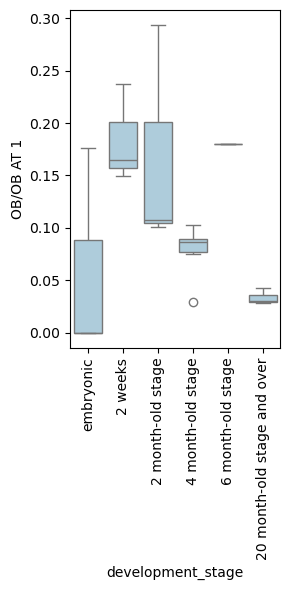

In [38]:
fig = plt.figure(figsize=(3,6))
ax = sns.boxplot(x=all_proportions['development_stage'],
                 y=all_proportions['OB/OB AT 1'], color=at_cmap['OB/OB AT 1'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
fig.savefig('figures/OB_OB_AT_1_development_stage_boxplot.png', dpi=300)

/tmp/ipykernel_2263428/1096354169.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


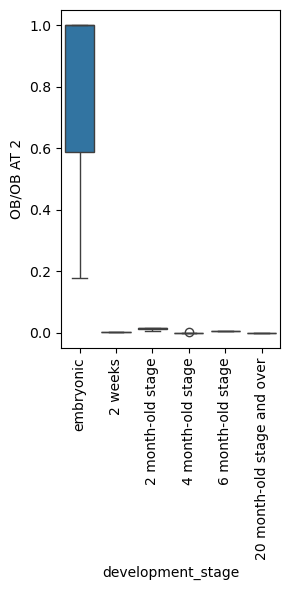

In [39]:
fig = plt.figure(figsize=(3,6))
ax = sns.boxplot(x=all_proportions['development_stage'],
                 y=all_proportions['OB/OB AT 2'], color=at_cmap['OB/OB AT 2'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
fig.savefig('figures/OB_OB_AT_2_development_stage_boxplot.png', dpi=300)

/tmp/ipykernel_2263428/4124673230.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


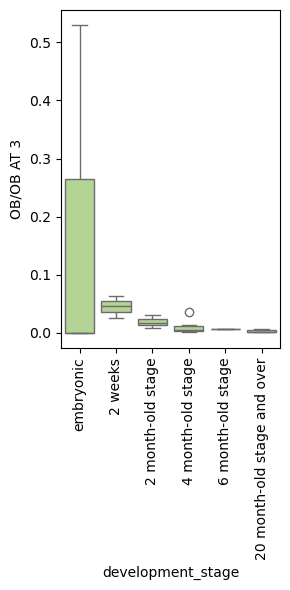

In [40]:
fig = plt.figure(figsize=(3,6))
ax = sns.boxplot(x=all_proportions['development_stage'],
                 y=all_proportions['OB/OB AT 3'], color=at_cmap['OB/OB AT 3'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
fig.savefig('figures/OB_OB_AT_3_development_stage_boxplot.png', dpi=300)